In [1]:
# System Imports
import os
import sys
import warnings
warnings.filterwarnings("ignore")
# Analysis Imports
import numpy as np
import pandas as pd
from scipy.signal import square
from scipy.integrate import simps as simpsons_integral
from scipy.integrate import trapz as trapezoid_integral
from scipy.optimize import fmin
from scipy.ndimage import label as binary_structuring
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
from scipy.signal import find_peaks_cwt, find_peaks
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

# ECG Library Function Imports
from [redacted]_processing.analysis import QueryAPI as Q
import [redacted]_processing.constants as CONST
import [redacted]_processing.utils as util
from [redacted]_processing.analysis import frequency_domain_analysis as fda
import [redacted]_processing.analysis.functional_interface.fourier_denoising as fdc
from [redacted]_processing.analysis import FullRankAnalyzer as parallelizer


# Retrieve the ECG to be processed. 

This ECG is approximately 80 hours long, and will be processed for signal quality.

In [2]:
queryAPI = Q.QueryAPI()
queryAPI.initialize(cache=False)
fra = parallelizer.FullRankAnalyzer()
fra.initialize(n_threads=CONST.N_THREADS, max_mem_pool=CONST.GB_SZ, shrMEM=False)

# Retrieve sample to process
ecg = queryAPI.retrieve_websample(fra)

# Generate the kernel for correlation

This is done in fourier_approx. Sample code for fourier_approx is available in this repository.
A plot of the kernel (in green) and QRS complex (blue dots) is below.

As per the paper, the Fourier routine uses the first few QRS complexes in the ECG data to generate coefficients. Once the coefficients are sufficiently stable (5% sequential difference), they can be used for further processing.

In [3]:
# Apply the fourier approximation to get the correlation kernel 
sample, kernel = fourier_approx(ecg, coef_order=5)

New fourier coefficients: [54.42424242424242, 30.71324452536212, 10.123252256937228, 3.520722121447471]; [0.0, 44.37820759428327, 26.981673894903697, 17.75032040449001]
New fourier coefficients: [31.972222222222218, 34.74195543859497, 11.868055555555557, 4.2083333333333295]; [0.0, 39.25003065683049, 29.91396082238748, 15.319444444444432]
New fourier coefficients: [30.8973559350394, 35.072099070988926, 11.09027777777778, 4.930555555555511]; [0.0, 42.514500249760268, 28.606481481481495, 15.294326460770092]
Approximation converged. Exiting...


Text(0, 0.5, 'Voltage (mV)')

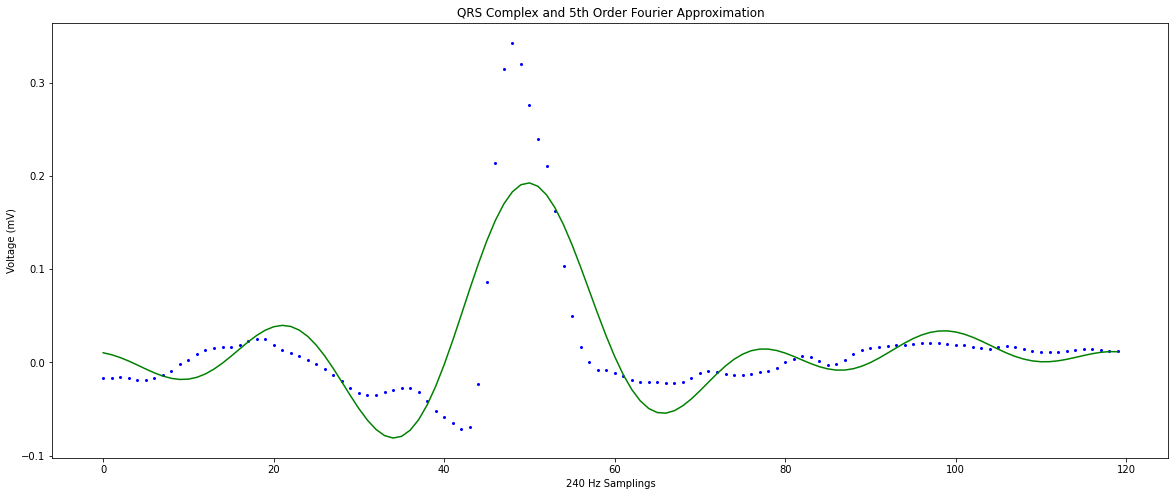

In [5]:
# Plotting the QRS complex used to model the kernel and the kernel itself (order=5 approximation)

plt.figure(figsize=(20, 8))
ax = plt.gca()
plt.plot(sample / 1000, 'bo', markersize=2)
plt.plot(kernel / 1000, color='green')
ax.set_title("QRS Complex and 5th Order Fourier Approximation")
ax.set_xlabel("240 Hz Samplings")
ax.set_ylabel("Voltage (mV)")

In [10]:
ecg['score'] = ecg.apply(lambda x: score(x), axis=1)
print('Mean score: {}'.format(ecg['score'].mean()))
print('Score st. dev: {}'.format(ecg['score'].std()))

Mean score: 10.923177967200884
Score st. dev: 2.5633225502874297


# Examples of signal stratification

The cutoff used in this example is 3 times the standard deviation of the scoring. As seen above, the mean is roughly 11, and the st. dev roughly 2.5.

Examples of signals stratified into (mean + 3 * std), (mean - 3 * std), and 'good quality' signal are plotted below.

In [11]:
m = ecg.score.mean()
s = ecg.score.std()
upper = ecg[ecg['score'] >= m + 3 * std]
lower = ecg[ecg['score'] <= m - 3 * std]

print("Number of out-of-distribution ECG segments")
print(len(ecg), len(upper), len(lower))
# 157,724 total 2-second intervals. (3,812 + 1,608) outside of 3 st. devs. = ~3% noise

Number of out-of-distribution ECG segments
157724 3812 1608


Text(0.5, 1.0, 'Obviously not a valid ECG signal!')

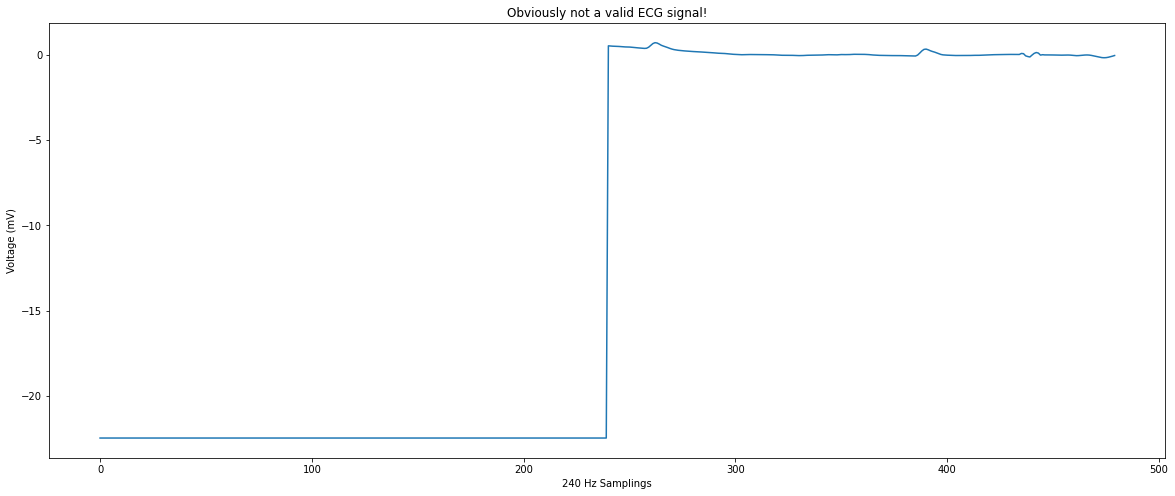

In [12]:
# Example of upper-out-of-bounds
ex = np.fromstring(upper.head(1).ts[0][1:-1], dtype=int, sep=',')
plt.figure(figsize=(20, 8))
plt.plot(ex / 1000)
ax = plt.gca()
ax.set_xlabel("240 Hz Samplings")
ax.set_ylabel("Voltage (mV)")
ax.set_title("Obviously not a valid ECG signal!")

Text(0.5, 1.0, 'Start and end of strip are not very readable')

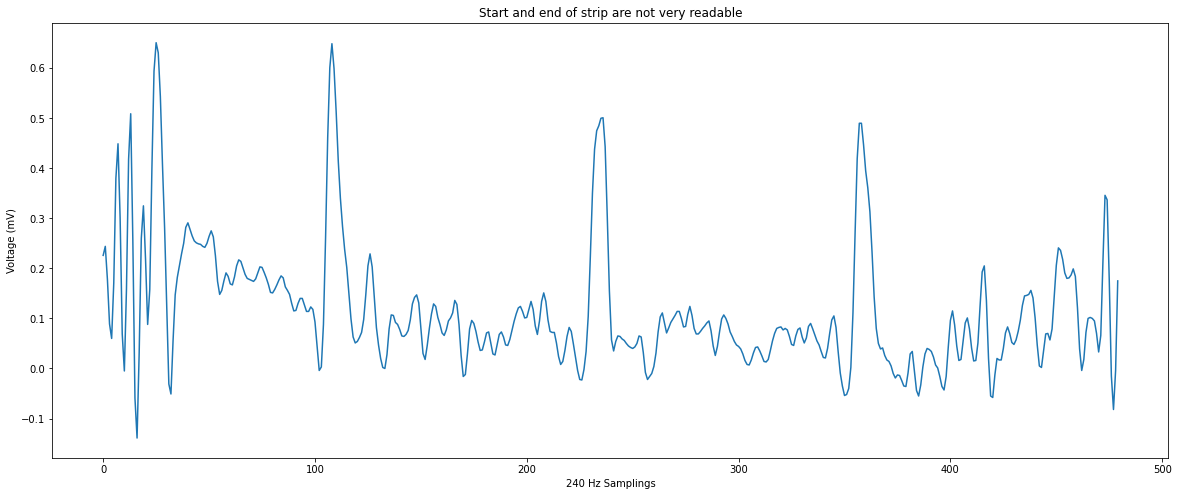

In [13]:
# Example of lower-out-of-bounds (i.e., score < mean - 3 * std)
ex = np.fromstring(lower.tail(1).ts[157683][1:-1], dtype=int, sep=',')
plt.figure(figsize=(20, 8))
plt.plot(ex / 1000)
ax = plt.gca()
ax.set_xlabel("240 Hz Samplings")
ax.set_ylabel("Voltage (mV)")
ax.set_title("Start and end of strip are not very readable")

Text(0.5, 1.0, 'Good Signal')

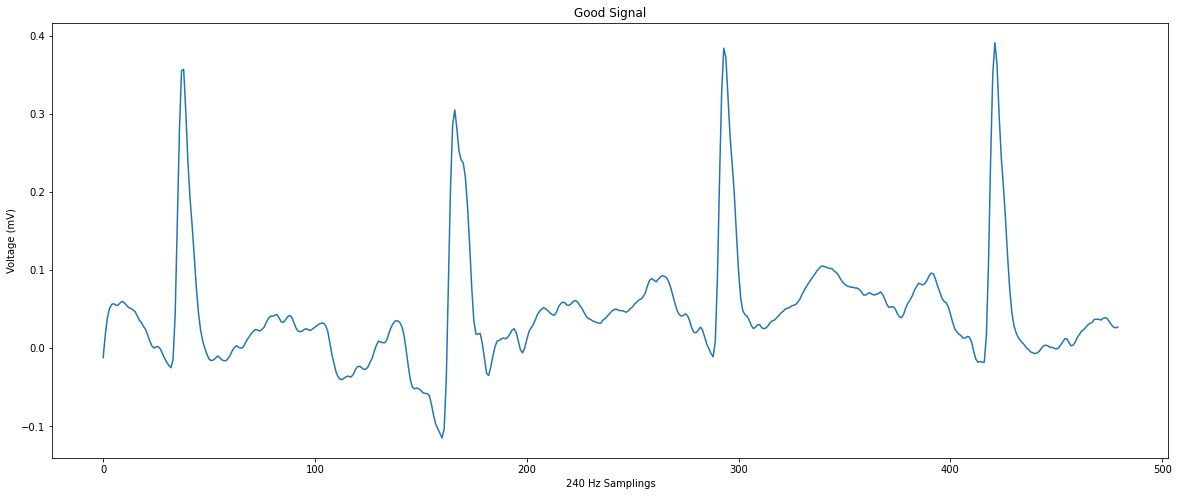

In [14]:
# Example of normal ECG
ecg = ecg[ecg['score'] <= m + 3 * s]
ecg = ecg[ecg['score'] >= m - 3 * s]
ex = np.fromstring(ecg.head(1).ts[1][1:-1], dtype=int, sep=',')
plt.figure(figsize=(20, 8))
plt.plot(ex / 1000)
ax = plt.gca()
ax.set_xlabel("240 Hz Samplings")
ax.set_ylabel("Voltage (mV)")
ax.set_title("Good Signal")